<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-1/1.2_chains_reducers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chains

## Review
We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 concepts:

- Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
- Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
- [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
- [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

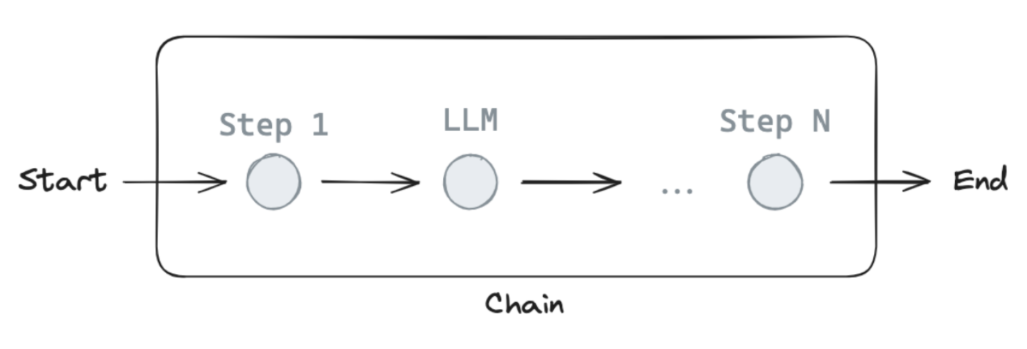

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

## Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

- `content` - content of the message
- `name` - optionally, a message author
- `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Rizwan"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Rizwan"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Rizwan

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Rizwan

I want to learn about the best place to see Orcas in the US.


## Chat Models
[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are many to choose from! Let's work with Gemini.

Let's check that your `GEMINI_API_KEY` is set and, if not, you will be asked to enter it.

In [ ]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
result

AIMessage(content='There isn\'t one single "best" place to see orcas in the US, as the best location depends on the time of year and what kind of orca viewing experience you\'re looking for.  Different populations of orcas have different ranges.  However, some of the most popular and reliable locations include:\n\n* **Washington State (San Juan Islands):** This is arguably the most famous location for orca watching in the US.  The resident orcas (Southern Resident Killer Whales) are found here year-round, but sightings are not guaranteed every day.  The waters are relatively calm, making for comfortable viewing.  Many tour operators operate in this area.  This is a great place to see the endangered Southern Resident killer whales, but remember to choose a responsible tour operator that prioritizes the whales\' well-being.\n\n* **Alaska:**  Alaska boasts several locations with orcas, offering different experiences.  You\'ll find transient orcas (that hunt marine mammals) and resident or

In [ ]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

## Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and tool [calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.
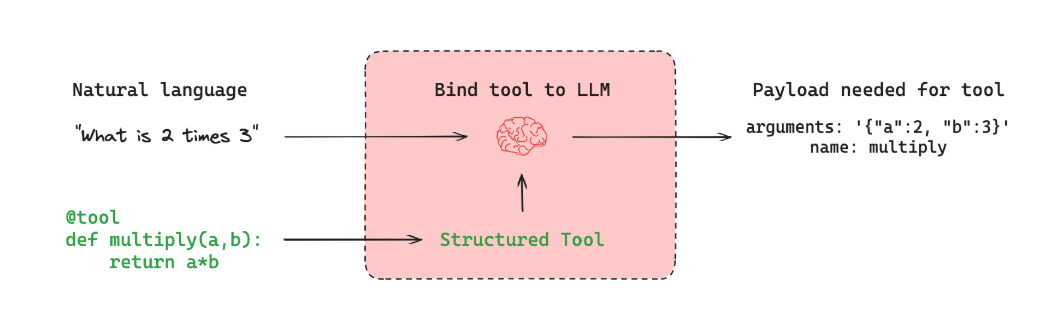

Let's showcase a simple example of tool calling!

The `multiply` function is our tool.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools: ChatGoogleGenerativeAI = llm.bind_tools([multiply])

In [ ]:
function_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Rizwan")])
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5f0e92f8-8c16-474d-98f4-bf4b396f9815-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'd547de33-2855-42d5-ba02-0021db23d3f5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 3, 'total_tokens': 60, 'input_token_details': {'cache_read': 0}})

In [ ]:
function_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}

## Using messages as state
With these foundations in place, we can now use messages in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built `MessagesState`!

`MessagesState` is defined:

- With a pre-build single messages key
- This is a list of AnyMessage objects
- It uses the add_messages reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Rizwan")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='b11f166b-8f9a-430c-acf3-0dff36ebe02c'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Rizwan', id='0c58bc54-8e18-4420-8d7f-2d6f7bf7a569'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='3a8716d8-fefa-427e-8ed1-f02f81700f36')]

## Our graph
Now, lets use `MessagesState` with a graph.

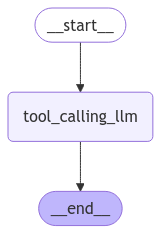

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph: CompiledStateGraph  = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 4 and 2!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 4 and 2!
================================== Ai Message ==================================
Tool Calls:
  multiply (fceb55a1-d193-440f-be5a-ac74b072ce30)
 Call ID: fceb55a1-d193-440f-be5a-ac74b072ce30
  Args:
    a: 4.0
    b: 2.0
